# Model Evaluation Part 2 -- Confidence Intervals and Resampling

## Iris Feature by Class Distribution in Random Subsampling

The following code will randomly divide the iris dataset into a 100-example training and 50-example test dataset to illustrate the issues that occur in non-stratified subsampling. I.e., the proportion of class labels in the training set will differ from the original dataset. Even worse, the proportion of class labels in the test set will be different too, depending on what the class label proportion is in the training set.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mlxtend.data import iris_data
from mlxtend.preprocessing import shuffle_arrays_unison

X, y = iris_data()

X, y = shuffle_arrays_unison([X, y], random_seed=123)
X_train, X_test = X[:100], X[100:150]
y_train, y_test = y[:100], y[100:150]

In [2]:
np.bincount(y)

array([50, 50, 50], dtype=int64)

In [3]:
np.bincount(y_train)

array([38, 28, 34], dtype=int64)

In [4]:
np.bincount(y_test)

array([12, 22, 16], dtype=int64)

In [5]:
df = pd.DataFrame(X)
df['class'] = y

df_train = pd.DataFrame(X_train)
df_train['class'] = y_train

df_test = pd.DataFrame(X_test)
df_test['class'] = y_test

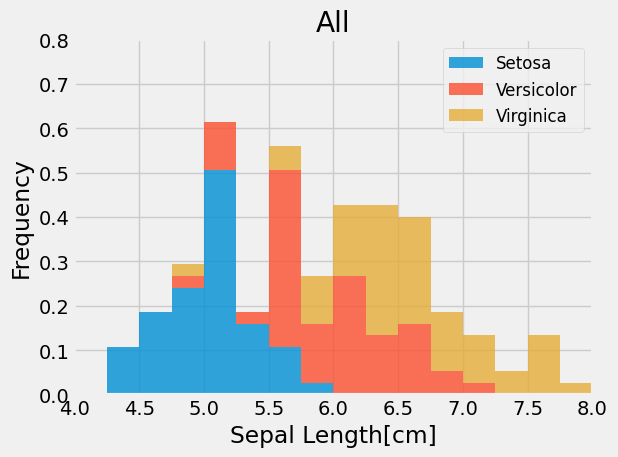

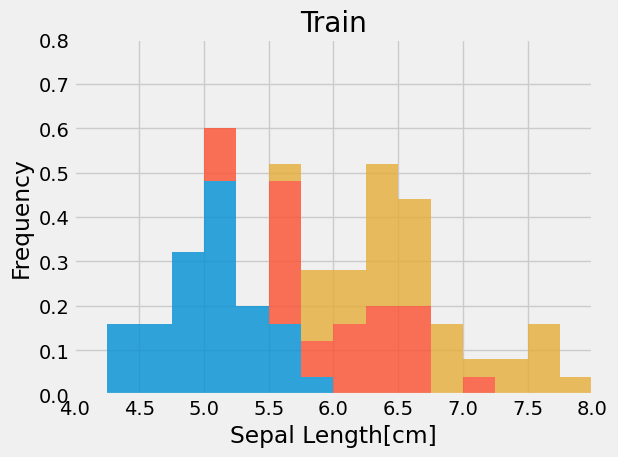

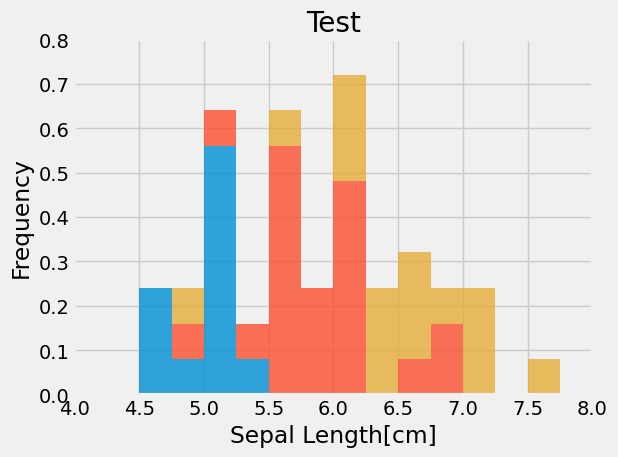

In [6]:
def stackhist(x, y, **kws):
    grouped = x.groupby(y)
    data = [d for _, d in grouped]
    labels = [l for l, _ in grouped]
    plt.hist(data, 
             histtype="barstacked", 
             label=labels, 
             alpha=0.8, 
             density=True,
             bins=np.arange(4.0, 8.1, 0.25))
    plt.ylim([0, 0.8])
    plt.xlim([4, 8])
    plt.xlabel('Sepal Length[cm]')
    plt.ylabel('Frequency')
    

with plt.style.context('fivethirtyeight'):    

    stackhist(df[0], df['class'])
    plt.legend(['Setosa', 'Versicolor', 'Virginica'], fontsize=12)
    plt.title('All')
    plt.tight_layout()
    #plt.savefig('./all.svg')
    plt.show()    

    stackhist(df_train[0], df_train['class'])
    plt.title('Train')
    plt.tight_layout()
    #plt.savefig('./train.svg')
    plt.show()    

    stackhist(df_test[0], df_test['class'])
    plt.title('Test')
    plt.tight_layout()
    #plt.savefig('./test.svg')
    plt.show() 
    

Note that these problems can be mitigated by using the `stratify` parameter in scikit-learn's [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function.

## Holdout method and repeated sampling

The following plots illustrate the issue of increasing the pessimistic bias of a performance estimate if we make the test set too large -- because we withold too many examples for model training such that the model doesn't reach it's capacity -- this assumes that we would fit the model on the whole training set after model evaluation. On the other hand, if we decrease the size of the test set, the estimate of the generalization performance will have a larger variance.

**Initialize KNN**

In [7]:
from mlxtend.data import iris_data
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

X, y = iris_data()

clf_1 = KNeighborsClassifier(n_neighbors=3,
                             weights='uniform', 
                             algorithm='kd_tree', 
                             leaf_size=30, 
                             p=2, 
                             metric='minkowski', 
                             metric_params=None, 
                             n_jobs=1)

**Large test set <=> small training set**

Average: 95.44%


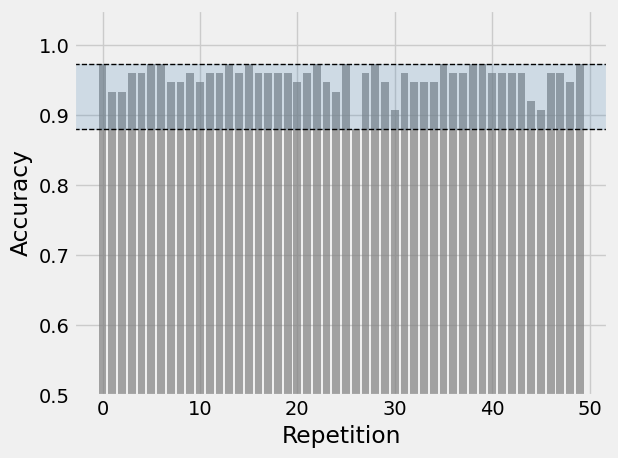

In [8]:
rng = np.random.RandomState(seed=12345)
seeds = np.arange(10**5)
rng.shuffle(seeds)
seeds = seeds[:50]

pred_2 = []

for i in seeds:
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.5, 
                                                        random_state=i,
                                                        stratify=y)
    y_pred_i = clf_1.fit(X_train, y_train).predict(X_test)
    y_pred_i_acc = np.mean(y_test == y_pred_i)
    pred_2.append(y_pred_i_acc)

pred_2 = np.asarray(pred_2)
print('Average: %.2f%%' % (pred_2.mean()*100))

with plt.style.context(('fivethirtyeight')):
    plt.bar(range(0, pred_2.shape[0]), pred_2, color='gray', alpha=0.7)
    plt.axhline(pred_2.max(), color='k', linewidth=1, linestyle='--')
    plt.axhline(pred_2.min(), color='k', linewidth=1, linestyle='--')
    plt.axhspan(pred_2.min(), pred_2.max(), alpha=0.2, color='steelblue')
    plt.ylim([0, pred_2.max() + 0.1])
    plt.xlabel('Repetition')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1.05])
    plt.tight_layout()
    #plt.savefig('figures/model-eval-iris_0.svg')
    plt.show()

**Small test set <=> larger training set**

Average: 96.13%


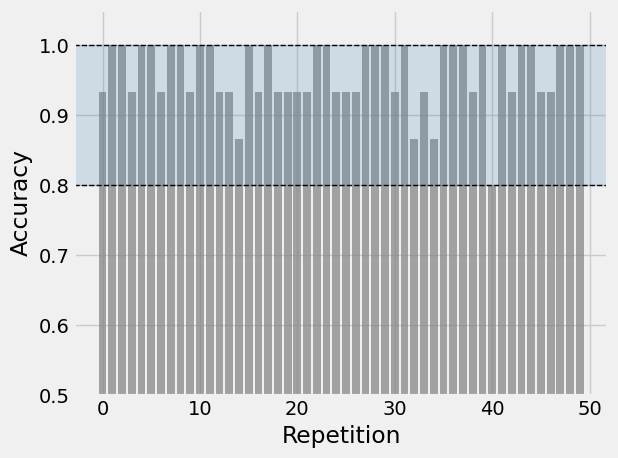

In [9]:
rng = np.random.RandomState(seed=12345)
seeds = np.arange(10**5)
rng.shuffle(seeds)
seeds = seeds[:50]

pred_2 = []

for i in seeds:
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.1, 
                                                        random_state=i,
                                                        stratify=y)
    y_pred_i = clf_1.fit(X_train, y_train).predict(X_test)
    y_pred_i_acc = np.mean(y_test == y_pred_i)
    pred_2.append(y_pred_i_acc)
    
pred_2 = np.asarray(pred_2)
print('Average: %.2f%%' % (pred_2.mean()*100))

with plt.style.context(('fivethirtyeight')):
    plt.bar(range(0, pred_2.shape[0]), pred_2, color='gray', alpha=0.7)
    plt.axhline(pred_2.max(), color='k', linewidth=1, linestyle='--')
    plt.axhline(pred_2.min(), color='k', linewidth=1, linestyle='--')
    plt.axhspan(pred_2.min(), pred_2.max(), alpha=0.2, color='steelblue')
    plt.ylim([0, pred_2.max() + 0.1])
    plt.xlabel('Repetition')
    plt.ylabel('Accuracy')
    plt.ylim(0.5, 1.05)
    plt.tight_layout()
    #plt.savefig('figures/model-eval-iris_0_2.svg')
    plt.show()

## Pessimistic Bias in Holdout

The following experiments further illustrate the issue of the pessimistic bias of the generalization performance estimates using learning curves. Here, the same test set is used while a model is fit on training sets with different sizes.

In [10]:
from mlxtend.data import mnist_data
from sklearn.model_selection import train_test_split


X2, y2 = mnist_data()
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2,
                                                        test_size=0.3, 
                                                        random_state=12,
                                                        stratify=y2)
print('Number of train examples:', y_train2.shape[0])
print('Number of test examples:', y_test2.shape[0])
print('Labels:', y_train2)

Number of train examples: 3500
Number of test examples: 1500
Labels: [8 8 7 ... 6 9 8]


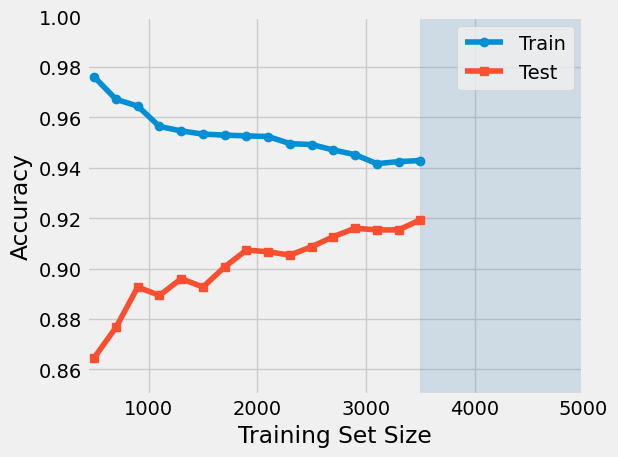

In [11]:
from sklearn.linear_model import LogisticRegression

clf_2 = LogisticRegression(penalty='l2', 
                           dual=False, 
                           tol=0.0001, 
                           C=0.000001, 
                           fit_intercept=True, 
                           intercept_scaling=1, 
                           class_weight=None, 
                           random_state=12, 
                           solver='lbfgs', 
                           max_iter=1000, 
                           multi_class='multinomial', 
                           verbose=0, 
                           warm_start=False, 
                           n_jobs=1)

pred_train, pred_test = [], []

intervals = np.arange(500, X_train2.shape[0] + 1, 200)

for i in intervals:
    clf_2.fit(X_train2[:i], y_train2[:i])
    p_train = clf_2.score(X_train2[:i], y_train2[:i])
    p_test = clf_2.score(X_test2, y_test2)
    pred_train.append(p_train)
    pred_test.append(p_test)
    
    
with plt.style.context(('fivethirtyeight')):
    plt.plot(intervals, pred_train, marker='o', label='Train')
    plt.plot(intervals, pred_test, marker='s', label='Test')
    plt.legend(loc='best', numpoints=1)
    plt.xlim([430, X_train2.shape[0] + X_test2.shape[0]])
    plt.axvspan(X_train2.shape[0], 
                X_train2.shape[0] + X_test2.shape[0], 
                alpha=0.2, 
                color='steelblue')
    plt.ylim([0.85, 1.0])
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.show()
    #plt.savefig('figures/model-eval-mnist_0.svg')

As it can be seen, the model is likely benefitting from more training data.

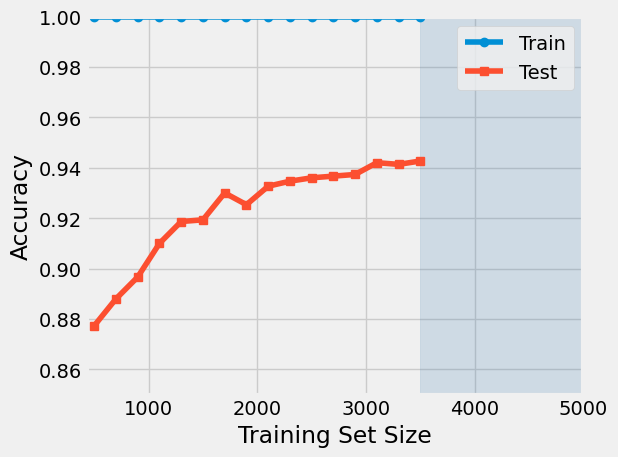

In [12]:
from sklearn.ensemble import RandomForestClassifier


clf_2 = RandomForestClassifier(n_estimators=100, random_state=123)

pred_train, pred_test = [], []

intervals = np.arange(500, X_train2.shape[0] + 1, 200)

for i in intervals:
    clf_2.fit(X_train2[:i], y_train2[:i])
    p_train = clf_2.score(X_train2[:i], y_train2[:i])
    p_test = clf_2.score(X_test2, y_test2)
    pred_train.append(p_train)
    pred_test.append(p_test)
    
    
with plt.style.context(('fivethirtyeight')):
    plt.plot(intervals, pred_train, marker='o', label='Train')
    plt.plot(intervals, pred_test, marker='s', label='Test')
    plt.legend(loc='best', numpoints=1)
    plt.xlim([430, X_train2.shape[0] + X_test2.shape[0]])
    plt.axvspan(X_train2.shape[0], 
                X_train2.shape[0] + X_test2.shape[0], 
                alpha=0.2, 
                color='steelblue')
    plt.ylim([0.85, 1.0])
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.show()
    #plt.savefig('figures/model-eval-mnist_0.svg')

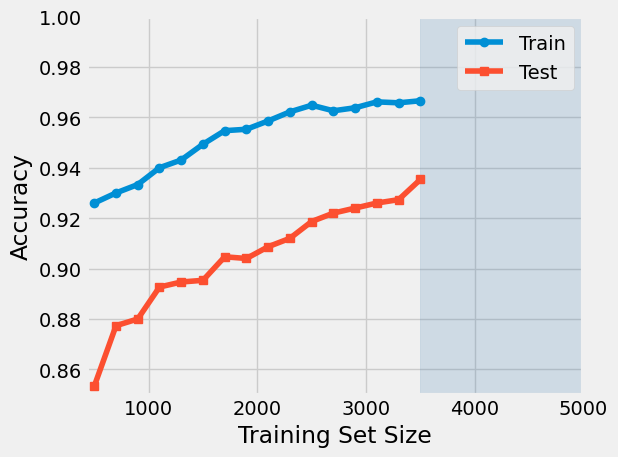

In [13]:
from sklearn.neighbors import KNeighborsClassifier


clf_2 = KNeighborsClassifier(n_neighbors=3)

pred_train, pred_test = [], []

intervals = np.arange(500, X_train2.shape[0] + 1, 200)

for i in intervals:
    clf_2.fit(X_train2[:i], y_train2[:i])
    p_train = clf_2.score(X_train2[:i], y_train2[:i])
    p_test = clf_2.score(X_test2, y_test2)
    pred_train.append(p_train)
    pred_test.append(p_test)
    
    
with plt.style.context(('fivethirtyeight')):
    plt.plot(intervals, pred_train, marker='o', label='Train')
    plt.plot(intervals, pred_test, marker='s', label='Test')
    plt.legend(loc='best', numpoints=1)
    plt.xlim([430, X_train2.shape[0] + X_test2.shape[0]])
    plt.axvspan(X_train2.shape[0], 
                X_train2.shape[0] + X_test2.shape[0], 
                alpha=0.2, 
                color='steelblue')
    plt.ylim([0.85, 1.0])
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.show()
    #plt.savefig('figures/model-eval-mnist_0.svg')

## Confidence Intervals

In this section, we are comparing the confidence intervals from using the normal approximation and using the bootstrap percentile method.

### Iris Simulation

In [14]:
from mlxtend.data import iris_data
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split



X, y = iris_data()

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.15, 
                                                    random_state=12345,
                                                    stratify=y)

clf = KNeighborsClassifier(n_neighbors=3,
                           weights='uniform', 
                           algorithm='kd_tree', 
                           leaf_size=30, 
                           p=2, 
                           metric='minkowski', 
                           metric_params=None, 
                           n_jobs=1)

#### Out-of-Bag (OOB) Bootstrap; Bootstrapping Training Sets -- Setup Step

- If you don't tune your model on the training set, you actually don't need a test set for this approach

In [15]:
import numpy as np


rng = np.random.RandomState(seed=12345)
idx = np.arange(y_train.shape[0])

bootstrap_train_accuracies = []

for i in range(200):
    
    train_idx = rng.choice(idx, size=idx.shape[0], replace=True)
    test_idx = np.setdiff1d(idx, train_idx, assume_unique=False)
    
    boot_train_X, boot_train_y = X_train[train_idx], y_train[train_idx]
    boot_test_X, boot_test_y = X_train[test_idx], y_train[test_idx]
    
    clf.fit(boot_train_X, boot_train_y)
    acc = clf.score(boot_test_X, boot_test_y)
    bootstrap_train_accuracies.append(acc)

bootstrap_train_mean = np.mean(bootstrap_train_accuracies)
bootstrap_train_mean

0.9551334744187693

#### Bootstrap 1-sample Confidence Interval (Based on OOB Estimates)

In [16]:
se = np.sqrt( (1. / (200-1)) * np.sum([(acc - bootstrap_train_mean)**2 
                                       for acc in bootstrap_train_accuracies])) 
ci = 1.97 * se  # 1.97 based on T distribution

bootstrap_na_lower = bootstrap_train_mean-ci
bootstrap_na_upper = bootstrap_train_mean+ci

print(bootstrap_na_lower, bootstrap_na_upper)

0.9005142524456666 1.009752696391872


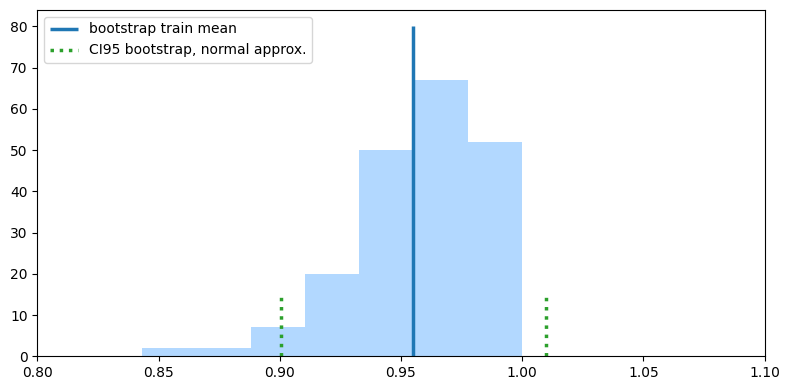

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(8, 4))
ax.vlines( bootstrap_train_mean, [0], 80, lw=2.5, linestyle='-', label='bootstrap train mean')

ax.vlines(bootstrap_na_upper, [0], 15, lw=2.5, linestyle='dotted', 
          label='CI95 bootstrap, normal approx.', color='C2')
ax.vlines(bootstrap_na_lower, [0], 15, lw=2.5, linestyle='dotted', color='C2')

ax.hist(bootstrap_train_accuracies, bins=7,
        color='#0080ff', edgecolor="none", 
        alpha=0.3)
plt.legend(loc='upper left')

plt.xlim([0.8, 1.1])
plt.tight_layout()
#plt.savefig('figures/bootstrap-histo-1.svg')

plt.show()

### Normal Approximation (No Bootstrap) Based on Test Set

In [18]:
clf.fit(X_train, y_train)
acc_test_na = clf.score(X_test, y_test)
ci_test_na = 1.96 * np.sqrt((acc_test_na*(1-acc_test_na)) / y_test.shape[0])

test_na_lower = acc_test_na-ci_test_na
test_na_upper = acc_test_na+ci_test_na

print(test_na_lower, test_na_upper)

0.8731774862637585 1.0398659919971112
